# vhPPIpred training, validating and testing

In [ ]:
## import module

import sys
sys.path.append("..")

import numpy as np
from utils import load_features, dimreduce, models, oversampling, figplot, ablation_experiment
import pandas as pd
from itertools import product
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns
import os

import time

import warnings
warnings.filterwarnings("ignore")

In [2]:
## split features

def feat_split(np_feat):
    np_feat_seq = np_feat[:, :2048]
    np_feat_hpdegree = np_feat[:, 2048]
    np_feat_hpdegree = np_feat_hpdegree[:, np.newaxis]
    np_feat_simi = np_feat[:, 2049:2051]
    np_feat_pssm = np_feat[:, 2051:2091]
    np_feat_label = np_feat[:, 2091]
    np_feat_label = np_feat_label[:, np.newaxis]

    return np_feat_seq, np_feat_hpdegree, np_feat_simi, np_feat_pssm, np_feat_label

In [3]:
## load data

def data_constructor(dt_dataset):
    for testI in range(1,7):
        dt_dataset_change = dt_dataset[dt_dataset["group"]!="gp_"+str(testI)].reset_index(drop=True)
        valIndexList = [int(x.split("_")[1]) for x in list(set(dt_dataset_change["group"]))]
        for valI in valIndexList:
            dt_train = dt_dataset_change[dt_dataset_change["group"]!="gp_"+str(valI)].reset_index(drop=True)
            dt_val = dt_dataset_change[dt_dataset_change["group"]=="gp_"+str(valI)].reset_index(drop=True)
            yield (testI, valI, dt_train, dt_val)

def data_constructor_for_multitest(dt_dataset):
    for testI in range(1,7):
        dt_train = dt_dataset[dt_dataset["group"]!="gp_"+str(testI)].reset_index(drop=True)
        dt_test = dt_dataset[dt_dataset["group"]=="gp_"+str(testI)].reset_index(drop=True)
        yield (testI, dt_train, dt_test)
    

# XGBoost

**Set PCA ratio of both seqEmbed and pssmEmbed to 0.9**

## 1. Cross-Validation

### 1.1 ensure n_estimators and learning_rate (other parameters with default settings)

In [4]:
## process of training and validation

def xgboost_train_val(dt_dataset, n_estimators, learning_rate, n_jobs):
    outF = open("../tmp_res/cvlog-xgboost-"+str(n_estimators)+"-"+str(learning_rate)+".txt", "w")
    NUM = 0
    for (testI, valI, dt_train, dt_val) in data_constructor(dt_dataset):
        ## load features
        feat_train, feat_val = load_features.loadfeatures(dataframe_train=dt_train, dataframe_test=dt_val, FeatPath="../../AllVirusAndHumanProteinEmbed/")
        ## oversampling
        feat_train = oversampling.oversampling(np_feat=feat_train, n_jobs=n_jobs)
        feat_train_seq, feat_train_hpdegree, feat_train_simi, feat_train_pssm, feat_train_label = feat_split(np_feat=feat_train)
        feat_val_seq, feat_val_hpdegree, feat_val_simi, feat_val_pssm, feat_val_label = feat_split(np_feat=feat_val)
        # pca
        feat_train_pca_seq, feat_val_pca_seq = dimreduce.dimreducePCA(feat_train=feat_train_seq, feat_test=feat_val_seq)
        feat_train_pca_pssm, feat_val_pca_pssm = dimreduce.dimreducePCA(feat_train=feat_train_pssm, feat_test=feat_val_pssm)
        feat_train_concat = np.concatenate([feat_train_pca_seq, feat_train_hpdegree, feat_train_simi, feat_train_pca_pssm, feat_train_label], axis=1) 
        feat_val_concat = np.concatenate([feat_val_pca_seq, feat_val_hpdegree, feat_val_simi, feat_val_pca_pssm, feat_val_label], axis=1) 
        # model
        train_loss, val_loss, train_error, val_error, model_name, accuracy, precision, recall, f1_s, auroc, auprc, *_  = models.xgboostForCVwithLossError(np_train=feat_train_concat, np_val=feat_val_concat, n_estimators=n_estimators, learning_rate=learning_rate, n_jobs=n_jobs)
        # out
        outF.write("%s\t%s\t%s\t%s\t%s\t%s\t%s\t%s\t%s\t%s\t%s\t%s\n" % (testI, valI, accuracy, precision, recall, f1_s, auroc, auprc, train_loss, val_loss, train_error, val_error))

        NUM+=1
        #print("{}/30".format(NUM), flush=True, end="\r")
        print("{}/30".format(NUM), flush=True)
        
    outF.close()

In [8]:
## set values of n_estimators and learning_rate
parameters_combination = {"n_estimators":[1500],
                          "learning_rate":[0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.3]
                          }


In [ ]:
## start training and validating

print("Start: ", time.ctime())
dt_dataset = pd.read_csv("../dataset/data_fold10.csv", sep="\t", header=0)

for (n_estimators, learning_rate) in product(parameters_combination["n_estimators"], parameters_combination["learning_rate"]):
    print("%s\t%s" % (n_estimators, learning_rate), flush=True)
    xgboost_train_val(dt_dataset, n_estimators=n_estimators, learning_rate=learning_rate, n_jobs=60)

print("End: ", time.ctime())

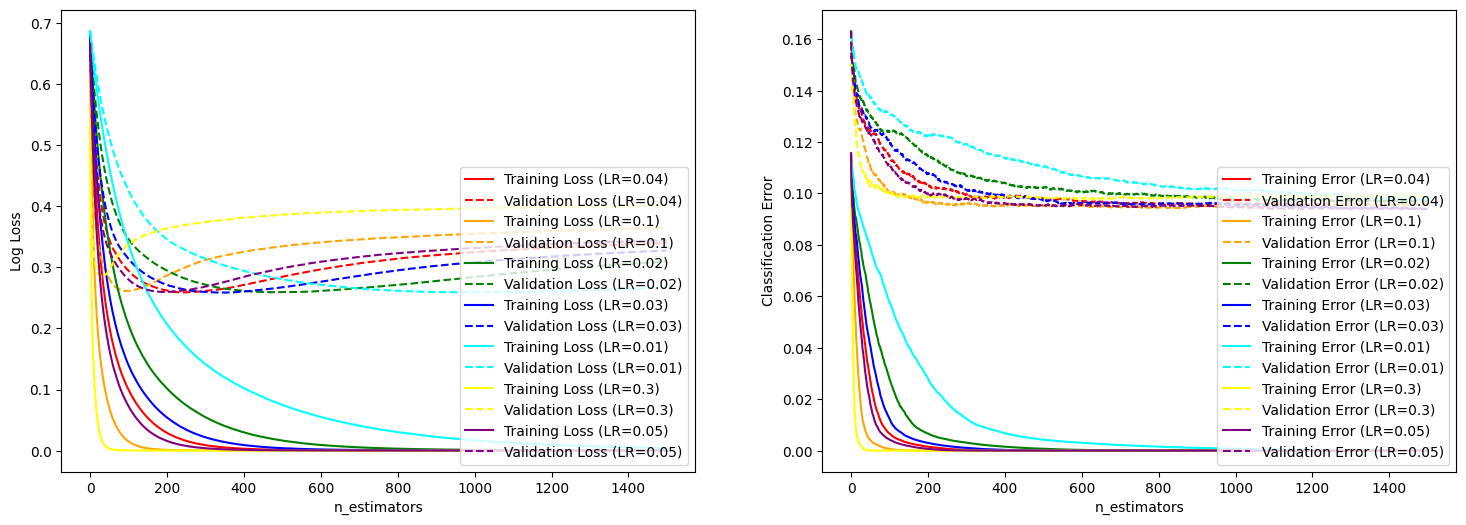

In [8]:
## visulization of error and loss, which ensure the values of n_estimators and learning_rate
import os
import pandas as pd
import matplotlib.pyplot as plt

def show_cv_error_loss(logfile):
    dt_train_loss, dt_val_loss, dt_train_error, dt_val_error = [], [], [], []
    with open(logfile) as inF:
        for line in inF:
            train_loss, val_loss, train_error, val_error = line.strip().split("\t")[-4].strip()[1:-1], line.strip().split("\t")[-3].strip()[1:-1], line.strip().split("\t")[-2].strip()[1:-1], line.strip().split("\t")[-1].strip()[1:-1]
            train_loss, val_loss, train_error, val_error = train_loss.split(","), val_loss.split(","), train_error.split(","), val_error.split(",")
            dt_train_loss.append(train_loss)
            dt_val_loss.append(val_loss)
            dt_train_error.append(train_error)
            dt_val_error.append(val_error)
    dt_train_loss = pd.DataFrame(dt_train_loss, dtype=float).T
    dt_val_loss = pd.DataFrame(dt_val_loss, dtype=float).T
    dt_train_error = pd.DataFrame(dt_train_error, dtype=float).T
    dt_val_error = pd.DataFrame(dt_val_error, dtype=float).T

    dt_train_loss["avg_train_loss"] = dt_train_loss.mean(axis=1)
    dt_val_loss["avg_val_loss"] = dt_val_loss.mean(axis=1)
    dt_train_error["avg_train_error"] = dt_train_error.mean(axis=1)
    dt_val_error["avg_val_error"] = dt_val_error.mean(axis=1)

    learning_rate = logfile.split("-")[-1][0:-4]
    return learning_rate, list(dt_train_loss["avg_train_loss"]), list(dt_val_loss["avg_val_loss"]), list(dt_train_error["avg_train_error"]), list(dt_val_error["avg_val_error"])


def runShow():
    logfileList = [f for f in os.listdir("../../tmp_res/") if f.startswith("cvlog-xgboost")]
    dict_train_loss, dict_val_loss, dict_train_error, dict_val_error = {}, {}, {}, {}
    for logfile in logfileList:
        lr, tl, vl, te, ve = show_cv_error_loss(logfile="../../tmp_res/"+logfile)
        dict_train_loss[lr] = tl
        dict_val_loss[lr] = vl
        dict_train_error[lr] = te
        dict_val_error[lr] = ve
    
    colors = ["red", "orange", "green", "blue", "cyan", "yellow", "purple"]
    plt.figure(figsize=(18, 6))
    
    plt.subplot(1, 2, 1)
    for i, lr in enumerate(dict_train_loss.keys()):
        plt.plot(range(0,len(dict_train_loss[lr])), dict_train_loss[lr], color=colors[i], linestyle='-', label=f'Training Loss (LR={lr})')
        plt.plot(range(0,len(dict_val_loss[lr])), dict_val_loss[lr], color=colors[i], linestyle='--', label=f'Validation Loss (LR={lr})')
    
    plt.xlabel('n_estimators')
    plt.ylabel('Log Loss')
    plt.legend(loc="lower right")

    plt.subplot(1, 2, 2)
    for i, lr in enumerate(dict_train_error.keys()):
        plt.plot(range(0,len(dict_train_error[lr])), dict_train_error[lr], color=colors[i], linestyle='-', label=f'Training Error (LR={lr})')
        plt.plot(range(0,len(dict_val_error[lr])), dict_val_error[lr], color=colors[i], linestyle='--', label=f'Validation Error (LR={lr})')
    
    plt.xlabel('n_estimators')
    plt.ylabel('Classification Error')
    plt.legend(loc="lower right")
    

## -------
runShow()


<font size=3> According to the changes of `Log Loss And Classification Error`, we set `n_estimators=600, lr=0.03`。</font>

### 1.2 set other parameters
We set other parameters (max_depth, min_child_weight, gamma, subsample, colsample_bytree) according to the mean value of AUROC and AUPRC.

In [6]:
## Train and validation

def xgboost_train_val_otherparameters(dt_dataset, filelabel, n_estimators, learning_rate, n_jobs, max_depth=6, min_child_weight=1, gamma=0, subsample=1, colsample_bytree=1):
    outF = open("../tmp_res/cvother-xgboost-"+filelabel+"-"+str(n_estimators)+"-"+str(learning_rate)+"-"+str(max_depth)+"-"+str(min_child_weight)+"-"+str(gamma)+"-"+str(subsample)+"-"+str(colsample_bytree)+".txt", "w")
    NUM = 0
    for (testI, valI, dt_train, dt_val) in data_constructor(dt_dataset):
        ## load features
        feat_train, feat_val = load_features.loadfeatures(dataframe_train=dt_train, dataframe_test=dt_val, FeatPath="../../AllVirusAndHumanProteinEmbed/")
        ## oversampling
        feat_train = oversampling.oversampling(np_feat=feat_train, n_jobs=n_jobs)
        feat_train_seq, feat_train_hpdegree, feat_train_simi, feat_train_pssm, feat_train_label = feat_split(np_feat=feat_train)
        feat_val_seq, feat_val_hpdegree, feat_val_simi, feat_val_pssm, feat_val_label = feat_split(np_feat=feat_val)
        # pca
        feat_train_pca_seq, feat_val_pca_seq = dimreduce.dimreducePCA(feat_train=feat_train_seq, feat_test=feat_val_seq)
        feat_train_pca_pssm, feat_val_pca_pssm = dimreduce.dimreducePCA(feat_train=feat_train_pssm, feat_test=feat_val_pssm)
        feat_train_concat = np.concatenate([feat_train_pca_seq, feat_train_hpdegree, feat_train_simi, feat_train_pca_pssm, feat_train_label], axis=1) 
        feat_val_concat = np.concatenate([feat_val_pca_seq, feat_val_hpdegree, feat_val_simi, feat_val_pca_pssm, feat_val_label], axis=1) 
        # model
        model_name, accuracy, precision, recall, f1_s, auroc, auprc  = models.xgboostForCVotherparameters(np_train=feat_train_concat, np_val=feat_val_concat, n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, min_child_weight=min_child_weight, gamma=gamma, subsample=subsample, colsample_bytree=colsample_bytree, n_jobs=n_jobs)
        # out
        outF.write("%s\t%s\t%s\t%s\t%s\t%s\t%s\t%s\n" % (testI, valI, accuracy, precision, recall, f1_s, auroc, auprc))

        NUM+=1
        #print("{}/30".format(NUM), flush=True, end="\r")
        print("{}/30".format(NUM), flush=True)
        
    outF.close()

In [ ]:
## max_depth, min_child_weight
parameters_combination = {"n_estimators":[600], #
                          "learning_rate":[0.03], #
                          "max_depth":[3,5,7,10],
                          "min_child_weight":[0.1,0.5,1,3,6,9]
                          }

## RUN
print("Start: ", time.ctime())
dt_dataset = pd.read_csv("../dataset/data_fold10.csv", sep="\t", header=0)

for (n_estimators, learning_rate, max_depth, min_child_weight) in product(parameters_combination["n_estimators"], parameters_combination["learning_rate"], parameters_combination["max_depth"], parameters_combination["min_child_weight"]):
    print("%s\t%s\t%s\t%s" % (n_estimators, learning_rate, max_depth, min_child_weight), flush=True)
    xgboost_train_val_otherparameters(dt_dataset, filelabel="maxdpminchildwt",n_estimators=n_estimators, learning_rate=learning_rate, n_jobs=60, max_depth=max_depth, min_child_weight=min_child_weight)

print("End: ", time.ctime())

In [14]:
## max_depth and min_child_weight according to the mean of AUROC and AUPRC

def best_maxdp_minchildwt(infile):
    max_depth, min_child_weight = infile.split("-")[5], infile.split("-")[6]
    dt = pd.read_csv(infile, sep="\t", names=["TestI","ValI","Accuracy","Precision","Recall","F1-Score","AUROC","AUPRC"])
    #return max_depth, min_child_weight, np.mean(dt["AUROC"]), np.mean(dt["AUPRC"])
    return max_depth, min_child_weight, np.min(dt["AUROC"]), np.min(dt["AUPRC"])

dt_maxdp_minchildwt = []
f_list = ["../tmp_res/"+f for f in os.listdir("../tmp_res/") if f.startswith("cvother-xgboost-maxdpminchildwt")]
for f in f_list:
    max_depth, min_child_weight, auroc, auprc = best_maxdp_minchildwt(infile=f)
    dt_maxdp_minchildwt.append([max_depth, min_child_weight, auroc, auprc])
dt_maxdp_minchildwt = pd.DataFrame(dt_maxdp_minchildwt, columns=["max_depth", "min_child_weight", "auroc", "auprc"])
dt_maxdp_minchildwt["mean_auc"] = (dt_maxdp_minchildwt["auroc"]+dt_maxdp_minchildwt["auprc"])/2
#dt_maxdp_minchildwt.sort_values(by=["auprc", "auroc"], ascending=[False, False], inplace=True, ignore_index=True)
dt_maxdp_minchildwt.sort_values(by=["mean_auc"], ascending=[False], inplace=True, ignore_index=True)
dt_maxdp_minchildwt.head(10)

,max_depth,min_child_weight,auroc,auprc,mean_auc
0,7,0.1,0.901472,0.528568,0.715020
1,7,3,0.901213,0.517060,0.709137
2,7,9,0.898179,0.517332,0.707756
3,7,6,0.898109,0.516549,0.707329
4,7,1,0.896876,0.516393,0.706634
5,10,6,0.895423,0.512000,0.703712
6,10,0.1,0.890237,0.513227,0.701732
7,10,9,0.892988,0.507619,0.700303
8,10,3,0.892034,0.507202,0.699618
9,10,0.5,0.893938,0.502174,0.698056


In [ ]:
## gamma
parameters_combination = {"n_estimators":[600], #
                          "learning_rate":[0.03], #
                          "max_depth":[7], #
                          "min_child_weight":[0.1], #
                          "gamma":[0, 0.1,0.2,0.3,0.4,0.5]
                          }

## RUN
print("Start: ", time.ctime())
dt_dataset = pd.read_csv("../dataset/data_fold10.csv", sep="\t", header=0)

for (n_estimators, learning_rate, max_depth, min_child_weight, gamma) in product(parameters_combination["n_estimators"], parameters_combination["learning_rate"], parameters_combination["max_depth"], parameters_combination["min_child_weight"], parameters_combination["gamma"]):
    print("%s\t%s\t%s\t%s\t%s" % (n_estimators, learning_rate, max_depth, min_child_weight, gamma), flush=True)
    xgboost_train_val_otherparameters(dt_dataset, filelabel="maxdpminchildwtgamma",n_estimators=n_estimators, learning_rate=learning_rate, n_jobs=60, max_depth=max_depth, min_child_weight=min_child_weight, gamma=gamma)

print("End: ", time.ctime())

In [16]:
## value of gamma

def best_maxdp_minchildwtgamma(infile):
    max_depth, min_child_weight, gamma = infile.split("-")[5], infile.split("-")[6], infile.split("-")[7]
    dt = pd.read_csv(infile, sep="\t", names=["TestI","ValI","Accuracy","Precision","Recall","F1-Score","AUROC","AUPRC"])
    #return max_depth, min_child_weight, np.mean(dt["AUROC"]), np.mean(dt["AUPRC"])
    return max_depth, min_child_weight, gamma, np.min(dt["AUROC"]), np.min(dt["AUPRC"])

dt_maxdp_minchildwtgamma = []
f_list = ["../tmp_res/"+f for f in os.listdir("../tmp_res/") if f.startswith("cvother-xgboost-maxdpminchildwtgamma")]
for f in f_list:
    max_depth, min_child_weigh, gamma, auroc, auprc = best_maxdp_minchildwtgamma(infile=f)
    dt_maxdp_minchildwtgamma.append([max_depth, min_child_weight, gamma, auroc, auprc])
dt_maxdp_minchildwtgamma = pd.DataFrame(dt_maxdp_minchildwtgamma, columns=["max_depth", "min_child_weight", "gamma", "auroc", "auprc"])
dt_maxdp_minchildwtgamma["mean_auc"] = (dt_maxdp_minchildwtgamma["auroc"]+dt_maxdp_minchildwtgamma["auprc"])/2
dt_maxdp_minchildwtgamma.sort_values(by=["mean_auc"], ascending=[False], inplace=True, ignore_index=True)
dt_maxdp_minchildwtgamma.head(5)



,max_depth,min_child_weight,gamma,auroc,auprc,mean_auc
0,7,0.1,0,0.900921,0.530654,0.715787
1,7,0.1,0,0.901472,0.528568,0.715020
2,7,0.1,0,0.901472,0.528568,0.715020
3,7,0.1,0,0.901039,0.524869,0.712954
4,7,0.1,0.1,0.897079,0.527124,0.712102


In [ ]:
## subsample and colsample_bytree
parameters_combination = {"n_estimators":[600], #
                          "learning_rate":[0.03], #
                          "max_depth":[7], #
                          "min_child_weight":[0.1], #
                          "gamma":[0],
                          "subsample":[0.8, 0.9, 1.0],
                          "colsample_bytree":[0.8, 0.9, 1.0]
                          }

## RUN
print("Start: ", time.ctime())
dt_dataset = pd.read_csv("../dataset/data_fold10.csv", sep="\t", header=0)

for (n_estimators, learning_rate, max_depth, min_child_weight, gamma, subsample, colsample_bytree) in product(parameters_combination["n_estimators"], parameters_combination["learning_rate"], parameters_combination["max_depth"], parameters_combination["min_child_weight"], parameters_combination["gamma"], parameters_combination["subsample"], parameters_combination["colsample_bytree"]):
    print("%s\t%s\t%s\t%s\t%s\t%s\t%s" % (n_estimators, learning_rate, max_depth, min_child_weight, gamma, subsample, colsample_bytree), flush=True)
    xgboost_train_val_otherparameters(dt_dataset, filelabel="maxdpminchildwtgammasample",n_estimators=n_estimators, learning_rate=learning_rate, n_jobs=60, max_depth=max_depth, min_child_weight=min_child_weight, gamma=gamma, subsample=subsample, colsample_bytree=colsample_bytree)

print("End: ", time.ctime())

In [19]:
## value of subsample and colsample_bytree

def best_maxdp_minchildwtgammasample(infile):
    max_depth, min_child_weight, gamma, subsample, colsample_bytree = infile.split("-")[5], infile.split("-")[6], infile.split("-")[7], infile.split("-")[8], infile.split("-")[9][0:-4]
    dt = pd.read_csv(infile, sep="\t", names=["TestI","ValI","Accuracy","Precision","Recall","F1-Score","AUROC","AUPRC"])
    #return max_depth, min_child_weight, np.mean(dt["AUROC"]), np.mean(dt["AUPRC"])
    return max_depth, min_child_weight, gamma, subsample, colsample_bytree, np.min(dt["AUROC"]), np.min(dt["AUPRC"])

dt_maxdp_minchildwtgammasample = []
f_list = ["../tmp_res/"+f for f in os.listdir("../tmp_res/") if f.startswith("cvother-xgboost-maxdpminchildwtgammasample")]
for f in f_list:
    max_depth, min_child_weigh, gamma, subsample, colsample_bytree, auroc, auprc = best_maxdp_minchildwtgammasample(infile=f)
    dt_maxdp_minchildwtgammasample.append([max_depth, min_child_weight, gamma, subsample, colsample_bytree, auroc, auprc])
dt_maxdp_minchildwtgammasample = pd.DataFrame(dt_maxdp_minchildwtgammasample, columns=["max_depth", "min_child_weight", "gamma", "subsample", "colsample_bytree", "auroc", "auprc"])
dt_maxdp_minchildwtgammasample["mean_auc"] = (dt_maxdp_minchildwtgammasample["auroc"]+dt_maxdp_minchildwtgammasample["auprc"])/2
dt_maxdp_minchildwtgammasample.sort_values(by=["mean_auc"], ascending=[False], inplace=True, ignore_index=True)
dt_maxdp_minchildwtgammasample.head(6)

,max_depth,min_child_weight,gamma,subsample,colsample_bytree,auroc,auprc,mean_auc
0,7,0.1,0,0.9,1.0,0.900921,0.530654,0.715787
1,7,0.1,0,1.0,1.0,0.901472,0.528568,0.715020
2,7,0.1,0,0.8,1.0,0.901039,0.524869,0.712954
3,7,0.1,0,0.8,0.9,0.899984,0.521615,0.710799
4,7,0.1,0,0.9,0.9,0.898451,0.520924,0.709687
5,7,0.1,0,0.9,0.8,0.903193,0.515401,0.709297


**Finally, we set : `n_estimators=600 , learning_rate=0.03 , max_depth=7 , min_child_weight=0.1 , gamma=0 , subsample=0.9 , colsample_bytree=1.0 `**

## 2. XGBoost multi-times test

In [4]:
## process of test

def xgboost_train_multitest(dt_dataset, n_jobs, pred_score_out=False, specificity=None):
    if pred_score_out:
        outF = open("../tmp_res/multestpredscore-xgboost.txt", "w")
    else:
        if specificity is None:
            outF = open("../tmp_res/multestfinal-xgboost.txt", "w")
        else:
            outF = open("../tmp_res/multestspecificity-xgboost-"+str(specificity)+".txt", "w")
    NUM = 0
    for (testI, dt_train, dt_test) in data_constructor_for_multitest(dt_dataset):
        ## load features
        feat_train, feat_test = load_features.loadfeatures(dataframe_train=dt_train, dataframe_test=dt_test, FeatPath="../../AllVirusAndHumanProteinEmbed/")
        ## oversampling
        feat_train = oversampling.oversampling(np_feat=feat_train, n_jobs=n_jobs)
        feat_train_seq, feat_train_hpdegree, feat_train_simi, feat_train_pssm, feat_train_label = feat_split(np_feat=feat_train)
        feat_test_seq, feat_test_hpdegree, feat_test_simi, feat_test_pssm, feat_test_label = feat_split(np_feat=feat_test)
        # pca
        feat_train_pca_seq, feat_test_pca_seq = dimreduce.dimreducePCA(feat_train=feat_train_seq, feat_test=feat_test_seq)
        feat_train_pca_pssm, feat_test_pca_pssm = dimreduce.dimreducePCA(feat_train=feat_train_pssm, feat_test=feat_test_pssm)
        feat_train_concat = np.concatenate([feat_train_pca_seq, feat_train_hpdegree, feat_train_simi, feat_train_pca_pssm, feat_train_label], axis=1) 
        feat_test_concat = np.concatenate([feat_test_pca_seq, feat_test_hpdegree, feat_test_simi, feat_test_pca_pssm, feat_test_label], axis=1) 
        # model and out
        if pred_score_out:
            pred_score, model_name, accuracy, precision, recall, f1_s, auroc, auprc, *_  = models.xgboostForMultiTest(np_train=feat_train_concat, np_test=feat_test_concat, n_jobs=n_jobs, pred_score_out=pred_score_out)
            for v in pred_score:
                outF.write("%s\t%f\n" % (testI, v))
        else:
            if specificity is None:
                model_name, accuracy, precision, recall, f1_s, auroc, auprc, *_  = models.xgboostForMultiTest(np_train=feat_train_concat, np_test=feat_test_concat, n_jobs=n_jobs)
                outF.write("%s\t%s\t%s\t%s\t%s\t%s\t%s\n" % (testI, accuracy, precision, recall, f1_s, auroc, auprc))
            else:
                model_name, accuracy, precision, recall, f1_s, auroc, auprc, *_  = models.xgboostForMultiTest(np_train=feat_train_concat, np_test=feat_test_concat, n_jobs=n_jobs, specificity=specificity)
                outF.write("%s\t%s\t%s\t%s\t%s\t%s\t%s\n" % (testI, accuracy, precision, recall, f1_s, auroc, auprc))

        NUM+=1
        print("{}/6".format(NUM), flush=True)
        
    outF.close()

### 2.1 select the threshold of score according to specificity


In [5]:
## run test

print("Start: ", time.ctime())

dt_dataset = pd.read_csv("../dataset/data_fold10.csv", sep="\t", header=0)
xgboost_train_multitest(dt_dataset, n_jobs=60, pred_score_out=True)

print("End: ", time.ctime())

Start:  Mon Aug 26 14:35:54 2024
1/6
2/6
3/6
4/6
5/6
6/6
End:  Mon Aug 26 14:51:53 2024


In [6]:
## set threshold according to specificity
## specificity: True Negative Rate, TNR = TN/(TN+FP)

def calculate_specificity(dt_dataset, TestI):
    ## dt_dataset: ["pred_score", "pred_label", "true_label"]
    dt_dataset.columns = ["pred_score", "true_label"]
    pred_scores = dt_dataset['pred_score'].values
    true_labels = dt_dataset['true_label'].values
    thresholds = np.sort(np.unique(pred_scores))[::-1]
    
    fp = 0
    tn = np.sum(true_labels == 0)
    
    specificities, precisions, recalls = [], [], []
    xx = 0
    
    for threshold in thresholds:
        pred_positive = pred_scores >= threshold
        
        fp += np.sum((true_labels == 0) & pred_positive)
        tn -= np.sum((true_labels == 0) & pred_positive)
        
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        
        specificities.append(specificity)
        
        xx += 1
        print("{}/{}".format(xx, len(thresholds)), end="\r", flush=True)
    
    result = pd.DataFrame({'Threshold': thresholds, 'Specificity': specificities})
    result.to_csv('../tmp_res/threshold_specificity_'+str(TestI)+'.csv', index=False, sep="\t")



def run_calculate_specificity():
    dt_true = pd.read_csv("../dataset/data_fold10.csv", sep="\t", header=0)
    dt_pred = pd.read_csv("../tmp_res/multestpredscore-xgboost.txt", sep="\t", names=["TestI", "pred_score"])
    for i in range(1,7):
        dt_true_i = dt_true[dt_true["group"]=="gp_"+str(i)].reset_index(drop=True)
        dt_pred_i = dt_pred[dt_pred["TestI"]==i].reset_index(drop=True)
        dt_res = pd.concat([dt_true_i, dt_pred_i], axis=1)
        dt_res = dt_res.loc[:,["pred_score","label"]]
        calculate_specificity(dt_dataset=dt_res, TestI=i)
        print("\n{}/6".format(i), flush=True)
        

print("START: ", time.ctime())
run_calculate_specificity()   
print("END: ", time.ctime())

START:  Mon Aug 26 14:54:21 2024
930/930
1/6
991/991
2/6
1914/1914
3/6
871/871
4/6
1080/1080
5/6
1029/1029
6/6
END:  Mon Aug 26 14:54:28 2024


In [7]:
## select final value according to specificity
dt_specificity_threshold = []
for i in range(1,7):
    dt_tmp = pd.read_csv("../tmp_res/threshold_specificity_"+str(i)+".csv", sep="\t", header=0)
    dt_tmp_100 = dt_tmp[dt_tmp["Specificity"]==1.0].reset_index(drop=True)
    v0999 = list(dt_tmp_100["Threshold"])[-1]
    dt_tmp_0999 = dt_tmp[dt_tmp["Specificity"]>=0.999].reset_index(drop=True)
    v100 = list(dt_tmp_100["Threshold"])[-1]
    dt_tmp_099 = dt_tmp[dt_tmp["Specificity"]>=0.99].reset_index(drop=True)
    v099 = list(dt_tmp_099["Threshold"])[-1]
    dt_tmp_095 = dt_tmp[dt_tmp["Specificity"]>=0.95].reset_index(drop=True)
    v095 = list(dt_tmp_095["Threshold"])[-1]
    dt_tmp_090 = dt_tmp[dt_tmp["Specificity"]>=0.90].reset_index(drop=True)
    v090 = list(dt_tmp_090["Threshold"])[-1]
    
    dt_specificity_threshold.append([i, v100, v099, v095, v090])
dt_specificity_threshold = pd.DataFrame(dt_specificity_threshold, columns=["TestI", "Spe100", "Spe099", "Spe095", "Spe090"])

print("Specificity=1.0 \tThreshold={}".format(max(dt_specificity_threshold["Spe100"])))
print("Specificity=0.999 \tThreshold={}".format(max(dt_specificity_threshold["Spe0999"])))
print("Specificity=0.99\tThreshold={}".format(max(dt_specificity_threshold["Spe099"])))
print("Specificity=0.95\tThreshold={}".format(max(dt_specificity_threshold["Spe095"])))
print("Specificity=0.90\tThreshold={}".format(max(dt_specificity_threshold["Spe090"])))
    

Specificity=1.0 	Threshold=0.999865
Specificity=0.99	Threshold=0.999856
Specificity=0.95	Threshold=0.999776
Specificity=0.90	Threshold=0.999638


### 2.3 All parameters of XGBoost：

```
    parameter settings of XGBoost:
        {n_estimators:600,
        learning_rate:0.03,
        max_depth:7,
        min_child_weight:0.1,
        gamma:0,
        subsample:0.9,
        colsample_bytree:1.0,
        specificity:[0.99, 0.95, 0.90],
        threshold:[0.999856, 0.999776, 0.999638]}
```

In [5]:
## output accuracy, precision, ...

parameters_combination = {"specificity":[0.99, 0.95, 0.90]}

print("Start: ", time.ctime())

dt_dataset = pd.read_csv("../dataset/data_fold10.csv", sep="\t", header=0)

for specificity in parameters_combination["specificity"]:
    xgboost_train_multitest(dt_dataset, n_jobs=60, specificity=specificity)

print("End: ", time.ctime())

Start:  Sun Aug 25 15:43:43 2024
1/6
2/6
3/6
4/6
5/6
6/6
1/6
2/6
3/6
4/6
5/6
6/6
1/6
2/6
3/6
4/6
5/6
6/6
End:  Sun Aug 25 16:31:45 2024


In [6]:
for spec in [0.99, 0.95, 0.90]:
    dt_tmp = pd.read_csv("../tmp_res/multestspecificity-xgboost-"+str(spec)+".txt", sep="\t", names=["TestI", "Accuracy", "Precision", "Recall", "F1-Score", "AUROC", "AUPRC"])
    accuracy, precision, recall, f1s, auroc, auprc = np.mean(dt_tmp["Accuracy"]), np.mean(dt_tmp["Precision"]), np.mean(dt_tmp["Recall"]), np.mean(dt_tmp["F1-Score"]), np.mean(dt_tmp["AUROC"]), np.mean(dt_tmp["AUPRC"])
    print("%s\t%.4f\t%.4f\t%.4f\t%.4f\t%.4f\t%.4f" % (spec, accuracy, precision, recall, f1s, auroc, auprc), flush=True)

## We select the result of specificity=0.99 as the finnal.

0.99	0.9134	0.9521	0.0502	0.0935	0.9205	0.6801
0.95	0.9157	0.9646	0.0759	0.1394	0.9205	0.6801
0.9	0.9197	0.9731	0.1192	0.2100	0.9205	0.6801
